<h2>KNN, linear discriminant analysis and logistic regression</center></h2>

### Imports

In [880]:
import numpy as np
import random
import operator
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import neighbors, model_selection
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import datasets, svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import mode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

### Data Generation

In [881]:
def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)

In [882]:
def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

In [883]:
def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    X = np.vstack([ex1, ex2, ex3])
    y = np.hstack([np.ones(n1), 2. * np.ones(n2), 3 * np.ones(n2)])

    ind = np.random.permutation(n1 + n2 + n3)
    np.random.shuffle(ind)
    return X[ind, :], y[ind]

In [884]:
def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

In [885]:
def rand_checkers(n1=100, n2=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [(i + j) % 3 + 1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nbp + nbn) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])

### Displaying labeled data

In [886]:
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']

def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=np.reshape(color_blind_list[i], (1, -1)), s=80,
                    marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

### Displaying tools for the Frontiere

In [887]:
def frontiere(f, data, step=50, cmap_choice=cm.coolwarm, tiny=False):
    """ trace la frontiere pour la fonction de decision f"""
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = f(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cmap_choice)
    if tiny:
        plt.xticks([])
        plt.yticks([])
    else:
        plt.colorbar()

In [888]:
def frontiere_new(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))

        
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    #print(z)
    #print(z.shape)
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1],
                        c=np.reshape(color_blind_list[label_num], (1, -1)),
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

### Algorithms and functions

In [889]:
class ErrorCurve(object):
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, Xtest, ytest):
        def error_func(k):
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            knn.fit(X, y)
            error = np.mean(knn.predict(Xtest) != ytest)
            return error

        errors = list(map(error_func, self.k_range))
        self.errors = np.array(errors)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.errors, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Test error")
        if maketitle:
            plt.title("number of training points : %d" % len(self.y))

In [890]:
class LOOCurve(object):
    """Leave-One-Out (LOO) curve"""
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, n_iter=200, random_state=1):
        def score_func(k):
            n_samples = len(X)
            # Selon la verson de scikit-learn : shuffleSplit prend en argument
            # 'niter ' ou niterations'. De plus, l'argument test_size peut ne
            # pas etre reconnu. Il est recommande de consulter
            # help(model_selection.ShuffleSplit) pour connaitre la liste
            # des arguments reconnus par votre version de sickitlearn.
            loo = model_selection.ShuffleSplit(n_iter,
                                                test_size=1,
                                                train_size=n_samples-1,
                                                random_state=random_state)
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            scores = model_selection.cross_val_score(estimator=knn,
                                                      X=X, y=y,
                                                      cv=loo)
            return np.mean(scores)

        scores = list(map(score_func, self.k_range))
        self.cv_scores = np.array(scores)
        self.y = y
        
    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, 1 - self.cv_scores, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Leave One Out Score (error rate)")
        if maketitle:
            plt.title("number of training points : %d" % (len(self.y) - 1))

1) Étudiez les fonctions rand_bi_gauss, rand_tri_gauss, rand_clown et rand_checkers. Que renvoient ces fonctions ? À quoi correspond la dernière colonne ? Générez les données en utilisant chaque
de ces 4 fonctions avec les valeurs des paramètres suivantes :

- pour rand_bi_gauss prenez 20 observations dans chaque classe centrées en (1, 1) et
(−1, −1), tous les écart-types égaux à 0.9 ;


In [891]:
X_1, y_1 = rand_bi_gauss(n1=20, n2=20, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9],
                  sigmas2=[0.9, 0.9])

- pour rand_tri_gauss générez 50 observations dans chaque classe, centrées en (1, 1),
(−1, −1) et (1, −1), tous les écart-types égaux à 0.9 ;

In [892]:
X_2, y_2 = rand_tri_gauss(n1=50, n2=50, n3=50, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.9, 0.9],
                   sigma2=[0.9, 0.9], sigma3=[0.9, 0.9])

- pour rand_clown prenez 50 pour les deux premiers arguments et 1 et 5 pour les deux suivants ;

In [893]:
X_3, y_3 = rand_clown(n1=50, n2=50, sigma1=1, sigma2=5)

— pour rand_checkers prenez 150 pour les deux premiers arguments et laissez le troisième par
défaut.

In [894]:
X_4, y_4 = rand_checkers(n1=150, n2=150, sigma=0.1)

2) Utilisez la fonction plot_2d afin d’afficher les jeux de données générés avec chacune des fonctions

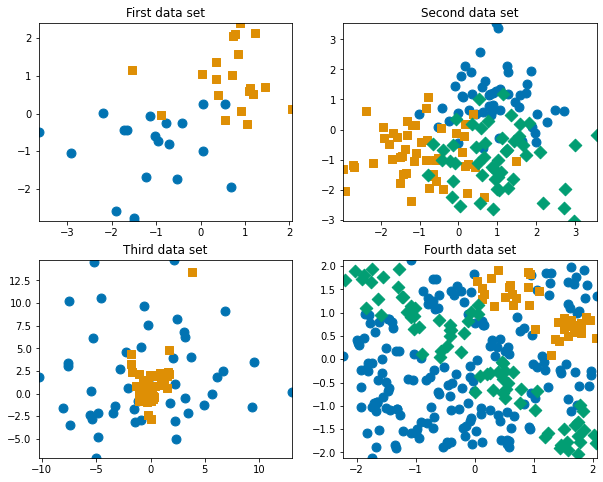

In [895]:
plt.figure(1, figsize=(10, 8))
plt.subplot(221)
plt.title('First data set')
plot_2d(X_1, y_1)
plt.subplot(222)
plt.title('Second data set')
plot_2d(X_2, y_2)
plt.subplot(223)
plt.title('Third data set')
plot_2d(X_3, y_3)
plt.subplot(224)
plt.title('Fourth data set')
plot_2d(X_4, y_4)

3) Proposez une version adaptée de cette méthode pour la régression, i.e., quand les observations y
sont à valeurs réelles : Y = R

k = 5 est préférable. Si on regarde les 11 plus proches voisins, on risque d'avoir le sous-apprentissage et d'avoir un modèle qui n'est pas précis.

4) Écrivez votre propre classe KNNClassifier avec les méthodes d’apprentissage fit et de classification
predict. Choisissez une stratégie de traitement des ex aequo, c’est-à-dire des points avec la même
distance ou le même nombre de points de chaque classe dans Vk(x). Vérifier la validité des résultats
en les comparant à ceux de la classe KNeighborsClassifier de scikit-learn en utilisant le jeu de
données #2. Vous proposerez votre propre méthode de comparaison (par exemple, en utilisant les
observations d’indice pair pour le set d’apprentissage et celles d’indice impair pour le set de test).
Vous pouvez utilisez le bloc de code si-dessous en complétant le méthodes proposées. Pour plus
d’information sur les classes on peut consulter par exemple http://docs.python.org/3/tutorial/
classes.html.

In [896]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KNNClassifier(BaseEstimator, ClassifierMixin):
# Homemade kNN classifier class

    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.m, self.n = X.shape      
        return self

    def predict(self, X):
        self.X_test = X
        self.m_test, self.n = X.shape
        y_predict = np.zeros(self.m_test)
        
        for i in range(self.m_test):
            x = self.X_test[i]
            neighbors = np.zeros(self.n_neighbors)
            neighbors = self.find_neighbors(x)[0]
            y_predict[i] = mode(neighbors)[0][0] #mode?
        return y_predict
    
    def find_neighbors(self, x):
        euclidean_distances = np.zeros(self.m)
        for i in range(self.m):
            d = self.euclidean(x, self.X_train[i])
            euclidean_distances[i] = d
        inds = euclidean_distances.argsort()
        y_train_sorted = self.y_train[inds]
        return y_train_sorted[:self.n_neighbors], d
    
    def euclidean(self, x, x_train):
        return np.sqrt(np.sum(np.square(x - x_train)))        


In [897]:
# On utilise les observations d’indice pair pour le set d’apprentissage et celles d’indice impair pour le set de test
X_train = X_2[::2]
y_train = y_2[::2]

X_test = X_2[1::2]
y_test = y_2[1::2]

In [898]:
# Avec KNNClasifier:
for i in np.arange(1,12): 
    knn = KNNClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    correct_answer = 0
    count = 0
    for count in range(np.size(y_pred)):
        if y_test[count] == y_pred[count]:
            correct_answer = correct_answer + 1
        count = count + 1
    print("Accuracy on test set: ", np.around((correct_answer / count) * 100, decimals=3))

Accuracy on test set:  68.0
Accuracy on test set:  65.333
Accuracy on test set:  69.333
Accuracy on test set:  73.333
Accuracy on test set:  77.333
Accuracy on test set:  69.333
Accuracy on test set:  72.0
Accuracy on test set:  68.0
Accuracy on test set:  70.667
Accuracy on test set:  72.0
Accuracy on test set:  72.0


In [899]:
# Avec scikit-learn comme vérification:
for i in np.arange(1,12): 
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    print("Accuracy on test set: ", np.around(accuracy_score(y_test, y_pred) * 100, decimals=3))

Accuracy on test set:  68.0
Accuracy on test set:  65.333
Accuracy on test set:  69.333
Accuracy on test set:  73.333
Accuracy on test set:  77.333
Accuracy on test set:  69.333
Accuracy on test set:  72.0
Accuracy on test set:  68.0
Accuracy on test set:  70.667
Accuracy on test set:  72.0
Accuracy on test set:  72.0


5) Faites tourner sur les quatre exemples de jeu de données cet algorithme de classification, en utilisant
la distance euclidienne classique d(x, v) = kx − vk2 et k = 5. Visualisez les règles de classification
obtenues en utilisant la fonction frontiere_new. (Souvent, les autres choix de distance peuvent
être utiles, par exemple la distance de Mahalanobis.)


In [900]:
def ff(x):
    pred = knn.predict(x.reshape(1,-1))
    return pred

In [901]:
X_list = [X_1, X_2, X_3, X_4]
y_list = [y_1, y_2, y_3, y_4]

Accuracy score on dataset 0 is: 100.0


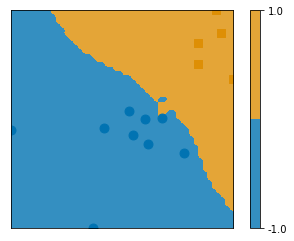

Accuracy score on dataset 1 is: 78.0


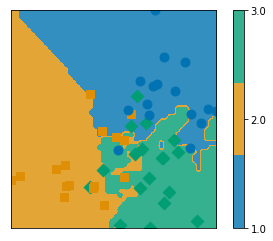

Accuracy score on dataset 2 is: 84.848


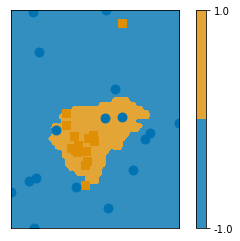

Accuracy score on dataset 3 is: 85.417


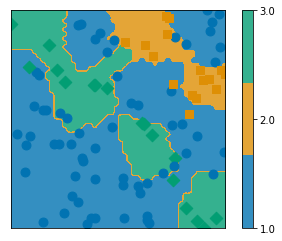

In [902]:
for i in range(len(X_list)):
    X = X_list[i]
    y = y_list[i]    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    knn = KNNClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)   
    print('Accuracy score on dataset', i, 'is:', np.around(accuracy_score(y_test, y_pred) * 100, decimals=3))
    frontiere_new(ff, X_test, y_test, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True)
    plt.show()

6) Pour les observations d’indice pair du jeu de données #2, faites varier le nombre k de voisins pris
en compte : k = 1, 2, . . . , n. Que devient la méthode dans le cas extrême où k = 1 ? k = n ? Afficher
ces cas sur les données étudiées en utilisant la fonction frontiere_new et présentez les dans une
forme facilement lisible. Dans quels cas la frontière est-elle complexe ? simple ?


Text(0, 0.5, 'Accuracy')

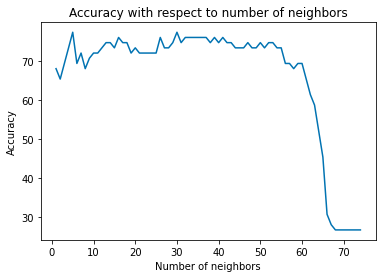

In [903]:
X = X_list[1]
y = y_list[1]    
X_train = X[::2]
y_train = y[::2]
X_test = X[1::2]
y_test = y[1::2]

accuracy = []
for k in np.arange(1, X_train.shape[0]):
    knn = KNNClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy.append(np.around(accuracy_score(y_test, y_pred) * 100, decimals=3))
plt.plot(np.arange(1, X_train.shape[0]), accuracy) 
plt.title("Accuracy with respect to number of neighbors")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")

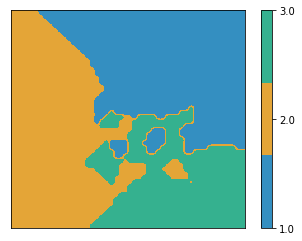

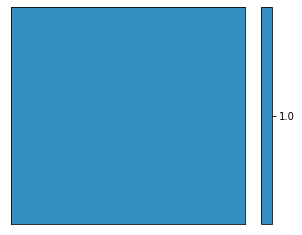

In [904]:
extreme_values = [1, X_train.shape[0]]

for k in extreme_values:
    knn = KNNClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)   
    frontiere_new(ff, X_test, y_test, w=None, step=50, alpha_choice=1, colorbar=True,
                      samples=False)
    plt.show()

Dans le cas où k=1, on ne prend en compte que le voisin le plus proche. On constate que la frontière est le plus complexe. Cela montre que la méthode mène à l'overfitting. 

Dans le cas où k=n, on prend en compte tous les voisins. On constate que la frontière est le plus simple (pas de frontière). Cela montre que la méthode mène à l'underfitting. 

7) Une variante possible très utilisée consiste à pondérer les poids du jème voisin selon e
−d
2
j /h (h
contrôlant le niveau de pondération) : cela revient à remplacer l’Équation (2) par :
ˆfk(x) ∈ arg max
y∈Y


X
k
j=1
exp(−d
2
j/h)1{yrj =y}

 . (3)
Implémentez cette variante dans scikit-learn en passant le paramètre weights au constructeur
de KNeighborsClassifier. (Une autre possibilité consiste à pondérer les variable et non seulement les observations, on le regarde pas ici.) On pourra s’inspirer de _weight_func de la partie
test de scikit-learn : https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/
neighbors/tests/test_neighbors.py Pour tester l’impact du choix de h sur les frontières de classification, visualisez les règles de classification pour k = 7 et h = 10j avec j = −2, −1, 0, 1, 2 ; utilisez
les observations d’indice pair du jeux de données #2 pour l’entrainement du classifieur (Vous pouvez
utiliser la fonction frontiere_new.)


In [905]:
X_train = X_list[1][::2]
y_train = y_list[1][::2]

X_test = X_list[1][1::2]
y_test = y_list[1][1::2]

h = -2


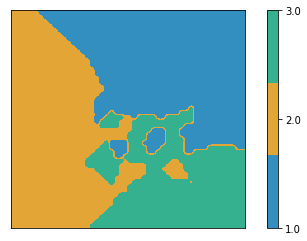

h = -1


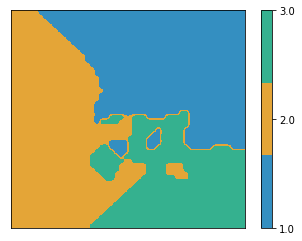

h = 0


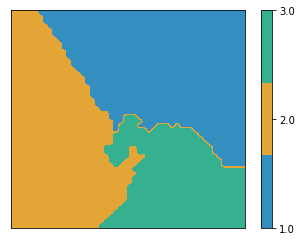

h = 1


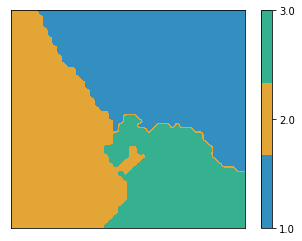

h = 2


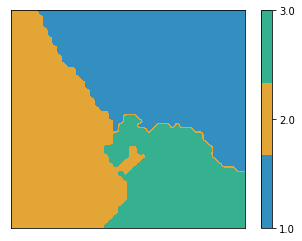

In [906]:
plt.figure(figsize=(8,4))
for j in range(-2,3):
    print(f"h = {j}")
    def _weight_func(array_dist):
        h = 10 ** j
        return np.exp(-array_dist**2/h)
    
    KNC = KNeighborsClassifier(n_neighbors=7, metric='minkowski', weights=_weight_func).fit(X_train, y_train)

    def f(x):
        return KNC.predict(x.reshape(1,-1))   

    frontiere_new(f, X_test, y_test, w=None, step=50, alpha_choice=1, colorbar=True,
                      samples=False)
    plt.show()

Quand j varie de -2 à 2, les frontières devienent de plus en plus lisses et régulières.

8) Quel est le taux d’erreur sur les mêmes données d’apprentissage (i.e., la proportion d’erreur faite
par le classifieur) lorsque k = 1 ? et sur des données de test (les observations d’indice pair) ?

In [907]:
# les données de test: les observations d'indice impair?

KNC = KNeighborsClassifier(n_neighbors=1, metric='minkowski', weights=_weight_func).fit(X_train, y_train)

y_pred_train = KNC.predict(X_train)
error_rate_train = np.around(np.mean(y_pred_train != y_train), decimals=3)

y_pred_test = KNC.predict(X_test)
error_rate_test = np.around(np.mean(y_pred_test != y_test), decimals=3)

print(f"Le taux d'erreur sur les données d'apprentissage lorsque k = 1 est de {error_rate_train}\net le taux d'erreur sur les données de test lorsque k = 1 est de {error_rate_test}")

Le taux d'erreur sur les données d'apprentissage lorsque k = 1 est de 0.0
et le taux d'erreur sur les données de test lorsque k = 1 est de 0.32


9) Pour le jeu de données #4, en utilisant les observations d’indice pair pour l’apprentissage et les observations d’indice impair pour le test, tracez le taux d’erreur en fonction de k pour k = 1, 2, . . . , 50.
Vous pourrez utiliser la classe fournie ErrorCurve.

In [908]:
X_train = X_list[3][::2]
y_train = y_list[3][::2]

X_test = X_list[3][1::2]
y_test = y_list[3][1::2]

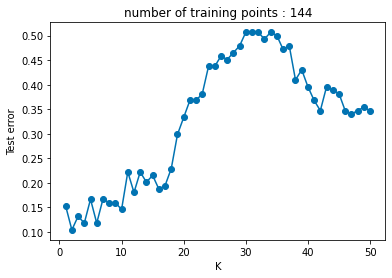

In [909]:
errorcurve = ErrorCurve(k_range=list(range(1, 51)))
errorcurve.fit_curve(X_train, y_train, X_test, y_test)
errorcurve.plot()

10) Tracez les différentes courbes d’erreur en fonction du paramètre k = (1, 2, . . . , 50) sur le jeu de
données #4, pour des nombres d’échantillons d’entrainement n prenant les valeurs 100, 200, 500 à
1000. Cette fois, tirez l’ensemble d’apprentissage et l’ensemble de test indépendamment et de même
taille. Quelle est la meilleure valeur de k ? Est-ce la même pour les différents datasets ? Vous pourrez
utiliser la classe fournie ErrorCurve. Pour n = 1000 visualisez les données et la règle de décision
sur le même graphique. (Vous pouvez utiliser la fonction frontiere_new.)


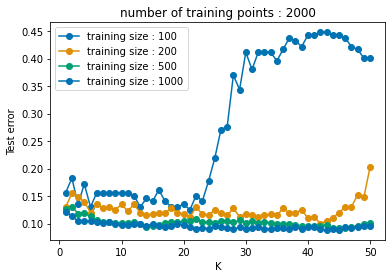

In [916]:
samples = [100, 200, 500, 1000]
n_samples = len(samples)

for i in range(n_samples):
    n1 = n2 = samples[i]
    X_train, y_train = rand_checkers(n1, n2, sigma=0.1)
    X_test, y_test = rand_checkers(n1, n2, sigma=0.1)
    errorcurve.fit_curve(X_train, y_train, X_test, y_test)
    errorcurve.plot()
plt.legend(["training size : %d" % n for n in n_values],
           loc='upper left')
plt.show()

Il semble que k=1 induit le moindre taux d'erreur parmi tous les datesets et tous les nombre d'échantillons.

In [918]:
X_train, y_train = rand_checkers(n1=1000, n2=1000, sigma=0.1)
X_test, y_test = rand_checkers(n1=1000, n2=1000, sigma=0.1)

k: 1


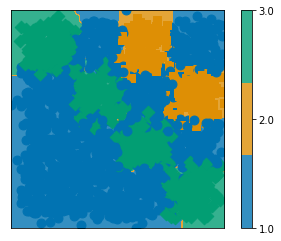

k: 2


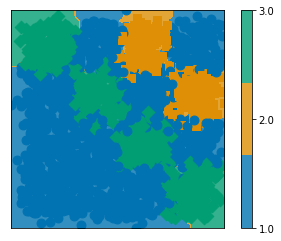

k: 3


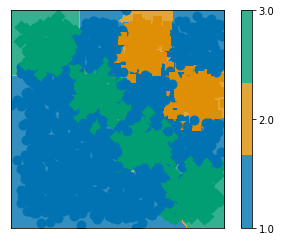

k: 4


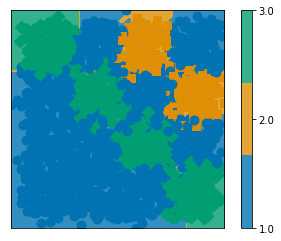

k: 5


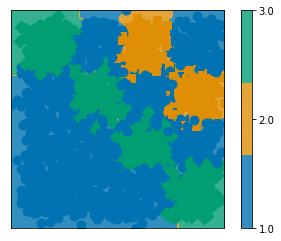

k: 6


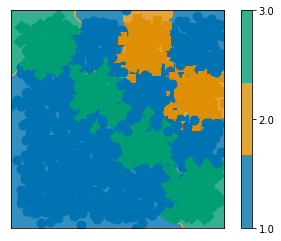

k: 7


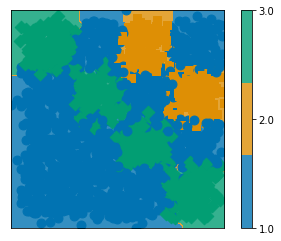

k: 8


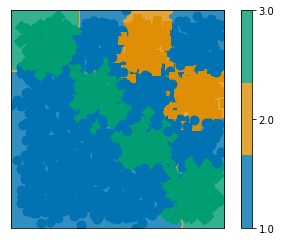

k: 9


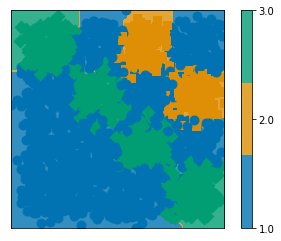

k: 10


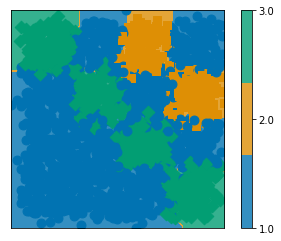

k: 11


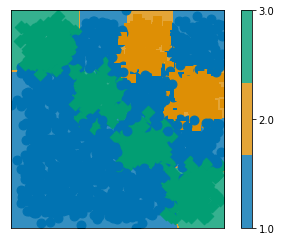

k: 12


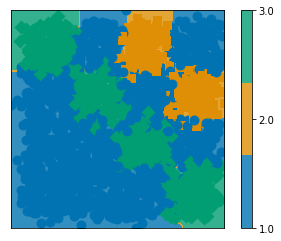

k: 13


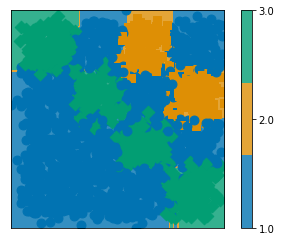

k: 14


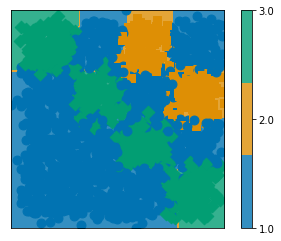

k: 15


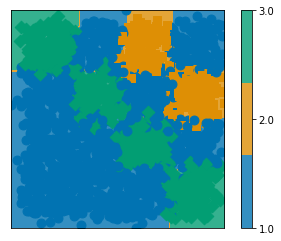

k: 16


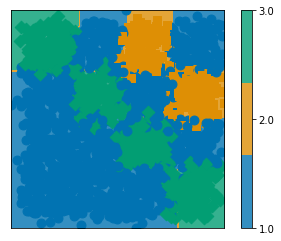

k: 17


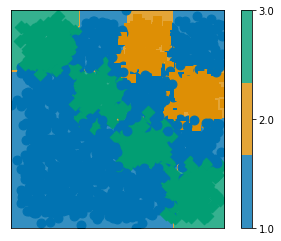

k: 18


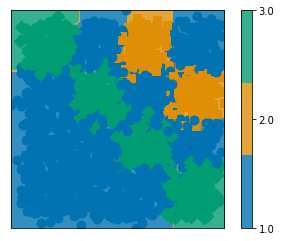

k: 19


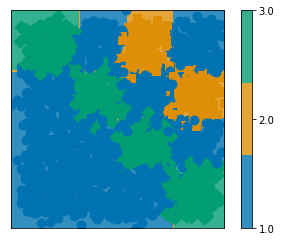

k: 20


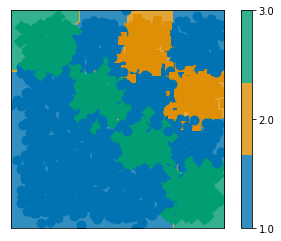

k: 21


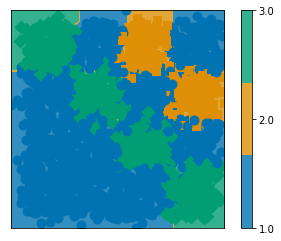

k: 22


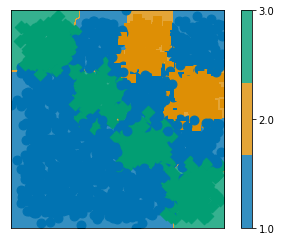

k: 23


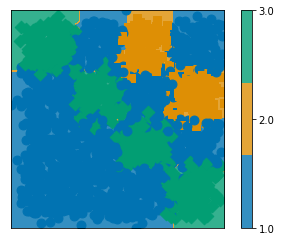

k: 24


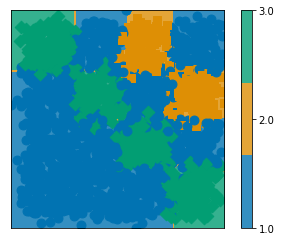

k: 25


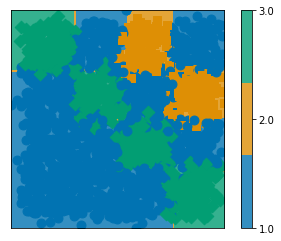

k: 26


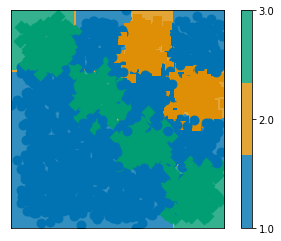

k: 27


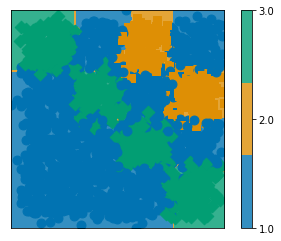

k: 28


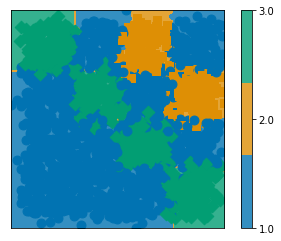

k: 29


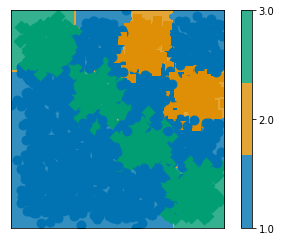

k: 30


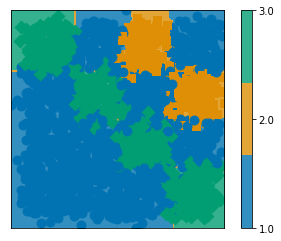

k: 31


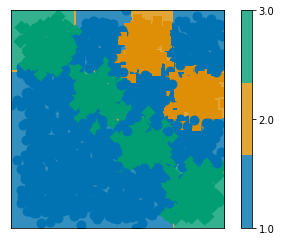

k: 32


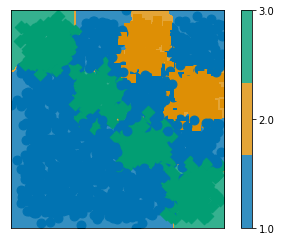

k: 33


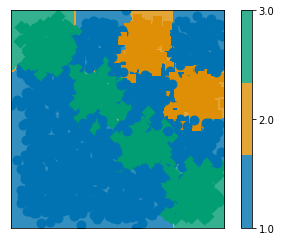

k: 34


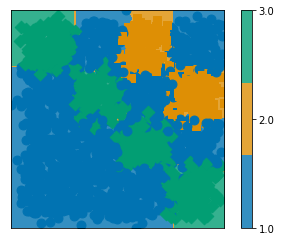

k: 35


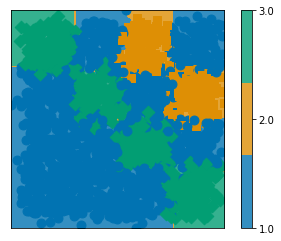

k: 36


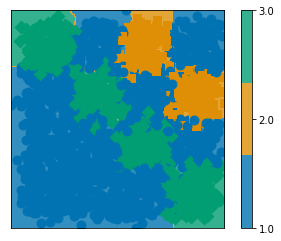

k: 37


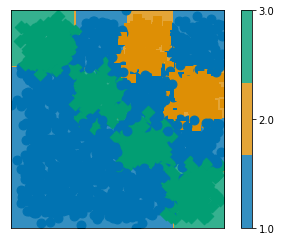

k: 38


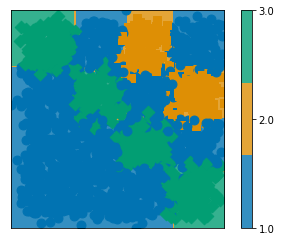

k: 39


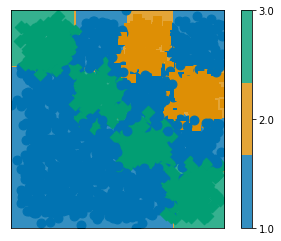

k: 40


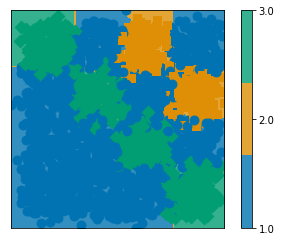

k: 41


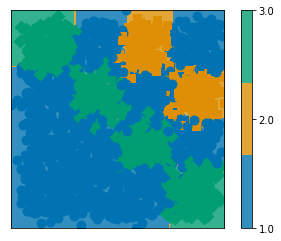

k: 42


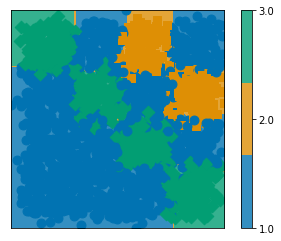

k: 43


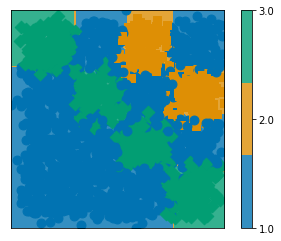

k: 44


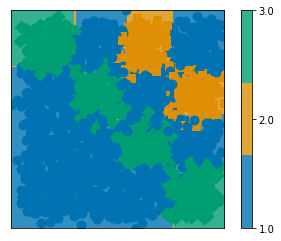

k: 45


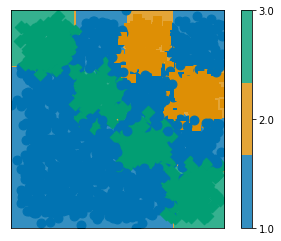

k: 46


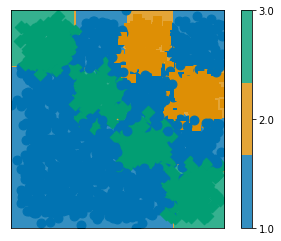

k: 47


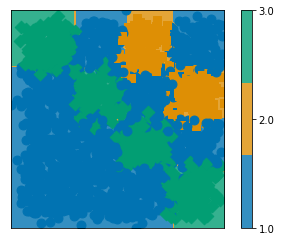

k: 48


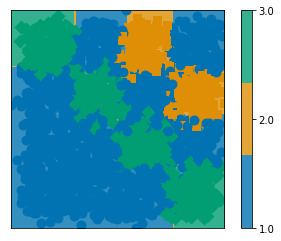

k: 49


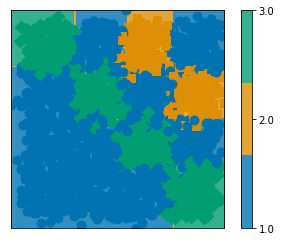

k: 50


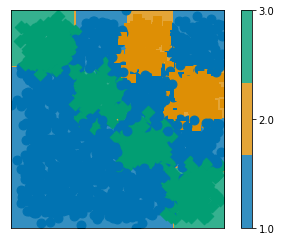

In [919]:
for k in range(1, 51):
    print("k: %d" % k)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    def f(x):
        return knn.predict(x.reshape(1,-1)) 
    frontiere_new(f, X_test, y_test, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True)
    plt.show()     

11) A votre avis, quels sont les avantages et les inconvénients de la méthode des plus proches voisins :
temps de calcul ? passage à l’échelle ? interprétabilité ?


Les avantages de la méthode des plus proches voisins sont:

1) cette méthode des plus proches voisins sont faciles à interpréter

2) cette méthode n'a pas besoin du temps d'entraînement

3) cette méthode est facile à mettre en place, car il n'y a que la distance à calculer

Les inconvénients de la méthode des plus proches voisins sont:

1) cette méthode ne fonctionne pas bien quand il s'agit d'une grande base de données ou de multiples dimensions, car il faut du temps pour calcuer toutes les distances

2) cette méthode est sensible aux données manquantes et aux bruits

3) les données dans toutes les dimensions doivent être normalisées

12) Étudiez la base digits de scikit-learn. On pourra se référer à https://scikit-learn.org/stable/
auto_examples/classification/plot_digits_classification.html pour le chargement et la
manipulation de la base de données. Décrivez la nature et le format des données (précisément),
affichez un exemple. Tracez l’histogramme pour des classes. Coupez l’échantillon en deux parties de
même taille et utilisez la première partie pour l’apprentissage et la deuxième pour le test. Appliquez
la méthode aux données issues de la base digits pour un choix de k ≥ 1 (e.g., k = 30) et indiquez
le taux d’erreur.


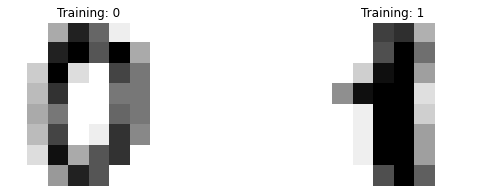

In [812]:
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [815]:
X = digits.images
y = digits.target
print(f"Il y a {X.shape[0]} images dans le jeu de données. \nChaque image a une taille de 8*8. \nIl y a {len(np.unique(y))} classes, soit {np.unique(y)}.")

Il y a 1797 images dans le jeu de données. 
Chaque image a une taille de 8*8. 
Il y a 10 classes, soit [0 1 2 3 4 5 6 7 8 9].


[178, 182, 177, 183, 181, 182, 181, 179, 174, 180]
Les classes sont plutôt équilibrées.


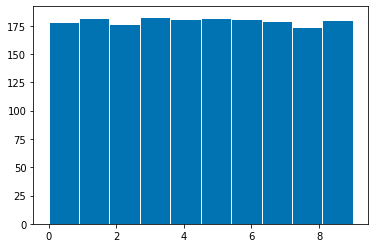

In [827]:
class_tot = []
for i in range(10):
    class_tot.append(np.sum(y==i))
print(class_tot)
plt.hist(y, edgecolor='white')
print("Les classes sont plutôt équilibrées.")

In [831]:
n_samples = len(X)
X = X.reshape((n_samples, -1))
y = y.ravel()

X_train = X[:n_samples // 2,:]
X_test = X[n_samples // 2:,:]
y_train = y[:n_samples // 2,]
y_test = y[n_samples // 2:,]
print(X_train.shape, y_train.shape)

(898, 64) (898,)


Le moindre taux d'erreur est de 0.037 avec la valeur de k: 3


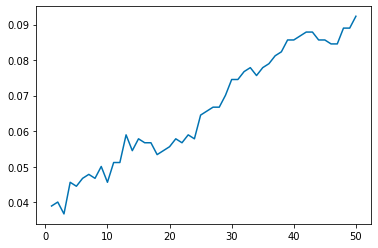

In [838]:
errors = []
for k in range(1,51):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    error = np.mean(knn.predict(X_test) != y_test)
    errors.append(error)
min_index, min_value = min(enumerate(errors), key=operator.itemgetter(1))
print(f"Le moindre taux d'erreur est de {np.around(min_value, decimals=3)} avec la valeur de k: {min_index+1}")
plt.plot(range(1,51), errors)    

13) Estimez la matrice de confusion (P{Y = i, Ck(X) = j})i, j associée au classifieur Ck ainsi
obtenu et visualisez celle-ci. Pour la manipulation de telles matrices avec scikit-learn, on
pourra consulter http://scikit-learn.org/stable/auto_examples/model_selection/plot_
confusion_matrix.html.

In [833]:
y_pred = knn.predict(X_test)

Confusion matrix, without normalization
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 77 10  1  0  1  0  0  0  2]
 [ 1  0 77  8  0  0  0  0  0  0]
 [ 0  0  0 81  0  3  0  4  1  2]
 [ 3  0  0  0 86  0  0  2  1  0]
 [ 0  0  0  1  0 81  2  0  0  7]
 [ 0  0  0  0  0  0 91  0  0  0]
 [ 0  0  0  0  0  0  0 89  0  0]
 [ 0  6  1  6  0  5  1  2 66  1]
 [ 1  0  0  4  0  4  0  2  0 81]]
Normalized confusion matrix
[[0.99 0.   0.   0.   0.01 0.   0.   0.   0.   0.  ]
 [0.   0.85 0.11 0.01 0.   0.01 0.   0.   0.   0.02]
 [0.01 0.   0.9  0.09 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.89 0.   0.03 0.   0.04 0.01 0.02]
 [0.03 0.   0.   0.   0.93 0.   0.   0.02 0.01 0.  ]
 [0.   0.   0.   0.01 0.   0.89 0.02 0.   0.   0.08]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.07 0.01 0.07 0.   0.06 0.01 0.02 0.75 0.01]
 [0.01 0.   0.   0.04 0.   0.04 0.   0.02 0.   0.88]]


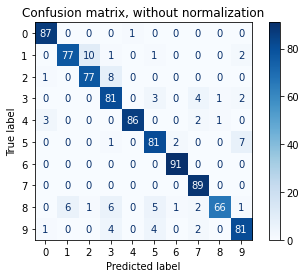

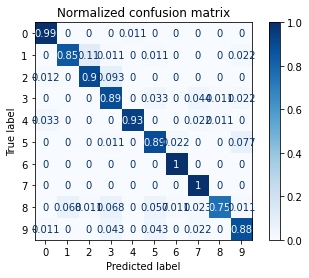

In [834]:
np.set_printoptions(precision=2)

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        knn,
        X_test,
        y_test,
        display_labels=np.unique(y),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

14) Proposez une méthode pour choisir k et mettez-la en œuvre. Vous pourrez utiliser la classe fournie
LOOCurve. En utilisant toutes les données, tracez la courbe du taux d’erreur leave-one-out pour
k = 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200. Pour plus d’information sur la validation croisée (crossvalidation) on peut consulter [?, Chapitre 7.10].

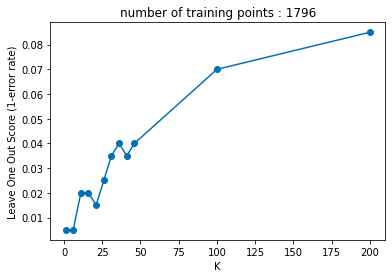

In [836]:
k_range = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200]
loocurve = LOOCurve(k_range=k_range)
loocurve.fit_curve(X,y)
loocurve.plot()
plt.show()

15) En utilisant la formule de Bayes donner la formule des probabilités a posteriori : P{Y = +1 | X = x},
P{Y = −1 | X = x}, comme fonctions de f+, f− et π+.

$$
\mathbb{P}({Y = +1} | {X = x}) = \frac {\mathbb{P}({X = x}|{Y = +1}) \mathbb{P}({Y = +1})}{\mathbb{P} ({X = x})}  =
\frac {{f_+} {\pi_+}}{{f_+} {\pi_+} + {f_-} {(1 - \pi_+)}}
$$

$$
\mathbb{P}({Y = -1} | {X = x}) = \frac {\mathbb{P}({X = x}|{Y = -1})  \mathbb{P}({Y = -1})}{\mathbb{P} ({X = x})}  =
\frac {{f_-} {(1 - \pi_+)}}{{f_+} {\pi_+} + {f_-}{(1 - \pi_+)}}
$$

16) Exprimer le log-ratio des deux classes :
$$
\log (\frac {\mathbb{P}\{Y = +1 | X = x\}} {\mathbb{P}\{Y = −1 | X = x\}})
$$
en fonction de π+, µ+, µ− et Σ.

$$
\log (\frac {\mathbb{P}\{Y = +1 | X = x\}} {\mathbb{P}\{Y = −1 | X = x\}})
= \log{\mathbb{P}({Y = +1}|{X = x})} - \log{\mathbb{P}({Y = -1}|{X = x})} 
$$

$$
 = \log({f_+}  {\pi_+}) - \log({f_+} {\pi_+} + {f_-}{(1 - \pi_+)}) - \log({f_-}  {(1 - \pi_+)}) + \log({f_+} {\pi_+} + {f_-} {(1 - \pi_+)})
$$

$$
 = \log{f_+} + \log{\pi_+} - \log{f_-} - \log{(1 - \pi_+)}
$$

$$
 = -1/2 * ({x} - {\mu_+})^T  \Sigma^{-1}  ({x} - {\mu_+}) +1/2 * ({x} - {\mu_-})^T  \Sigma^{-1}  ({x} - {\mu_-}) + \log{\pi_+} - \log{(1 - \pi_+)}
$$

$$
 = {x}^T \Sigma^{-1}  {\mu_+} -1/2 * {\mu_+}^T  \Sigma^{-1}  {\mu_+} - {x}^T  \Sigma^{-1}  {\mu_-} + 1/2 * {\mu_-}^T  \Sigma^{-1}  {\mu_-} + \log{\pi_+} - \log{(1 - \pi_+)}
$$

$$
 =  {x}^T \Sigma^{-1}  ({\mu_+} - {\mu_-}) - 1/2 * {\mu_+}^T  \Sigma^{-1}  {\mu_+} + 1/2 * {\mu_-}^T  \Sigma^{-1}  {\mu_-} - \log{(1 - \pi_+)} + \log{\pi_+}
$$

On utilise les formules suivantes:

$
{a}^T b = {b}^Ta
$

$
log(\frac {A} {B}) = log({A}) - log({B})
$

17) Justifier le choix du classifieur suivant :

Quand $
\log(\frac {\mathbb{P}({Y = +1}|{X = x})}{\mathbb{P}({Y = -1}|{X = x})}) > 0 
$

$
<=> \frac {\mathbb{P}({Y = +1}|{X = x})}{\mathbb{P}({Y = -1}|{X = x})} \geq 1 <=> \mathbb{P}({Y = +1}|{X = x}) \geq \mathbb{P}({Y = -1}|{X = x})
$

$
<=> {x}^T \hat\Sigma^{-1}  ({\hat\mu_+} - {\hat\mu_-}) \geq 1/2 * {\hat\mu_+}^T  \hat\Sigma^{-1}  {\hat\mu_+} - 1/2 * {\hat\mu_-}^T  \hat\Sigma^{-1}  {\hat\mu_-} + \log{(1 - \hat\pi_+)} - \log{\hat\pi_+}, 
$

$
 <=>{x}^T \hat\Sigma^{-1}  ({\hat\mu_+} - {\hat\mu_-}) \geq 1/2 * {\hat\mu_+}^T * \hat\Sigma^{-1}  {\hat\mu_+} - 1/2 * {\hat\mu_-}^T  \hat\Sigma^{-1}  {\hat\mu_-} + \log{(1 - m / n)} - \log{(m / n)}, 
$

Donc on peut assigner 1 pour ce cas-là et -1 dans le cas contraire.

18) Écrivez votre propre classe LDAClassifier avec les méthodes d’apprentissage fit et de classification
predict.

In [866]:
class LDA():
    
    def fit(self, X, y):
        X1 = X[y == np.unique(y)[1]]
        X2 = X[y == np.unique(y)[0]]

        cov1 = np.cov(X1.T)
        cov2 = np.cov(X2.T)
        m = len(X1)
        n = len(X)
        cov_total = 1 / (n - 2) * ((m - 1) * cov1 + (n - m - 1) * cov2)

        mean1 = X1.mean(axis=0)
        mean2 = X2.mean(axis=0)

        self.mul_1 = np.linalg.inv(cov_total) @ (mean1 - mean2)
        self.mul_2 = 0.5 * mean1.T @ np.linalg.inv(cov_total) @ mean1 - 0.5 * mean2.T @ np.linalg.inv(cov_total) @ mean2 - np.log(m / n) + np.log(1 - m / n)

    def predict(self, X):
        return (np.round(X @ self.mul_1 > self.mul_2)*2 - 1).astype(int)

19) Importez le module sklearn.discriminant_analysis qui contient en particulier la classe
LinearDiscriminantAnalysis qui nous servira dans la suite.

Vérifiez la validité des résultats obtenus avec votre méthode en les comparant à ceux de la classe
LinearDiscriminantAnalysis de scikit-learn en utilisant un jeu de données simulé. Vous proposerez votre propre méthode de comparaison (l’échantillon d’apprentissage doit être petit et l’échantillon de validation doit être assez grand ; on considère par ailleurs que m est différent de n − m,
i.e., les deux classes ne sont pas représentées par le même nombre d’échantillons observés). Indiquez
les taux d’erreur de LDAClassifier et de LinearDiscriminantAnalysis et le nombre de cas où les
prédictions coïncident. En utilisant votre classe LDAClassifier, visualisez la règle de classification.
(Vous pouvez utiliser la fonction frontiere_new.)

In [867]:
X, y = rand_bi_gauss(n1=100, n2=80, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.8, 0.8],
                  sigmas2=[0.8, 0.8])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42) # échantillon de validation? assez grand?

In [870]:
# Avec la classe LDAClassifier
lda = LDA()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
error_lda = np.around(np.mean(y_pred_lda!= y_test), decimals=3)
error_lda

0.056

In [871]:
# Avec la classe LinearDiscriminantAnalysis de scikit-learn

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)
error_clf = np.around(np.mean(y_pred_clf!= y_test), decimals=3)
error_clf

0.056

In [872]:
np.sum(y_pred_lda == y_pred_clf)

162

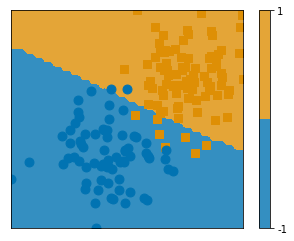

In [873]:
def f(x):
    return lda.predict(x.reshape(1,-1))   

frontiere_new(f, X_test, y_test, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True)
plt.show() 

20) En utilisant votre classe LDAClassifier, visualisez la règle de classification pour les jeux de données
#1 et #3. (Vous pouvez utiliser la fonction frontiere_new.) Discutez l’efficacité de la méthode
dans ces deux cas.

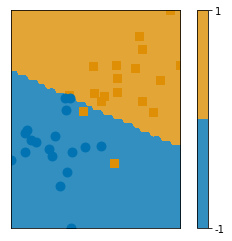

In [874]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.9, random_state=42)
def f(x):
    return lda.predict(x.reshape(1,-1))   

frontiere_new(f, X_test, y_test, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True)
plt.show()

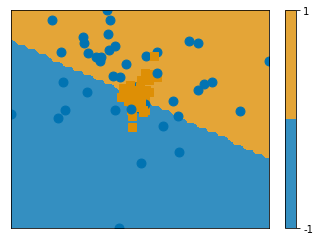

In [875]:
X_train, X_test, y_train, y_test = train_test_split(X_3, y_3, test_size=0.9, random_state=42)
def f(x):
    return lda.predict(x.reshape(1,-1))   

frontiere_new(f, X_test, y_test, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True)
plt.show()

Quand les sigmas de deux classes de données ne sont pas égaux, la méthode LDA est moins efficace.

21) Appliquez la classification par régression logistique sur les données rand_bi_gauss. Comparer les
résultats avec la LDA, notamment lorsque une classe est beaucoup plus petite que l’autre (a beaucoup moins d’observations). On parle alors de classes déséquilibrées.

In [876]:
X, y = rand_bi_gauss(n1=100, n2=20, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.8, 0.8],
                  sigmas2=[0.8, 0.8])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [877]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
error = np.mean(y_pred_lr != y_test)
error

0.025

22) À quoi correspond la variable coef_ du modèle ? intercept_ ?


In [922]:
print(lr.coef_, "\n" "la variable coef_ du modèle correspond aux coefficients des features dans la fonction de décision, \nun hyper plan qui sert de frontière de décision.")

[[1.62 1.38]] 
la variable coef_ du modèle correspond aux coefficients des features dans la fonction de décision, 
un hyper plan qui sert de frontière de décision.


In [843]:
print(lr.intercept_, "\n" "la variable intercept_ du modèle correspond au bias ajouté dans la fonction de décision")

[1.42] 
la variable intercept_ du modèle correspond au bias ajouté dans la fonction de décision


23) Utiliser la fonction frontiere_new pour visualiser la frontière de décision.


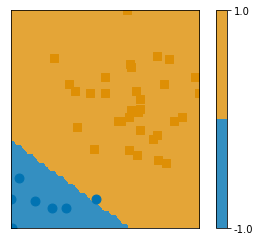

In [844]:
def f(x):
    return lr.predict(x.reshape(1,-1))   

frontiere_new(f, X_test, y_test, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True)
plt.show()

24) Appliquez la classification par régression logistique à des données issues de la base digits. Comme
précédemment, coupez l’échantillon en deux parties de même taille et utilisez la première partie
pour l’apprentissage et la deuxième pour tester. Indiquez le taux d’erreur.


In [845]:
digits = datasets.load_digits()
X = digits.images
y = digits.target

n_samples = len(X)
X = X.reshape((n_samples, -1))
y = y.ravel()

X_train = X[:n_samples // 2,:]
X_test = X[n_samples // 2:,:]
y_train = y[:n_samples // 2,]
y_test = y[n_samples // 2:,]

In [848]:
lr = LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
error = np.around(np.mean(y_pred_lr != y_test), decimals=3)
error

0.083